## Salary Prediction

**Predicting Salary for Developers based on the survery results by Stackoverflow**


In [1]:
# Read Data

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("survey_results_public.csv")

In [2]:
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [3]:
# Data Size

print(f'Number of Data Samples: {df.shape[0]}')
print(f'Number of Columns: {df.shape[1]}')

Number of Data Samples: 64461
Number of Columns: 61


<AxesSubplot:>

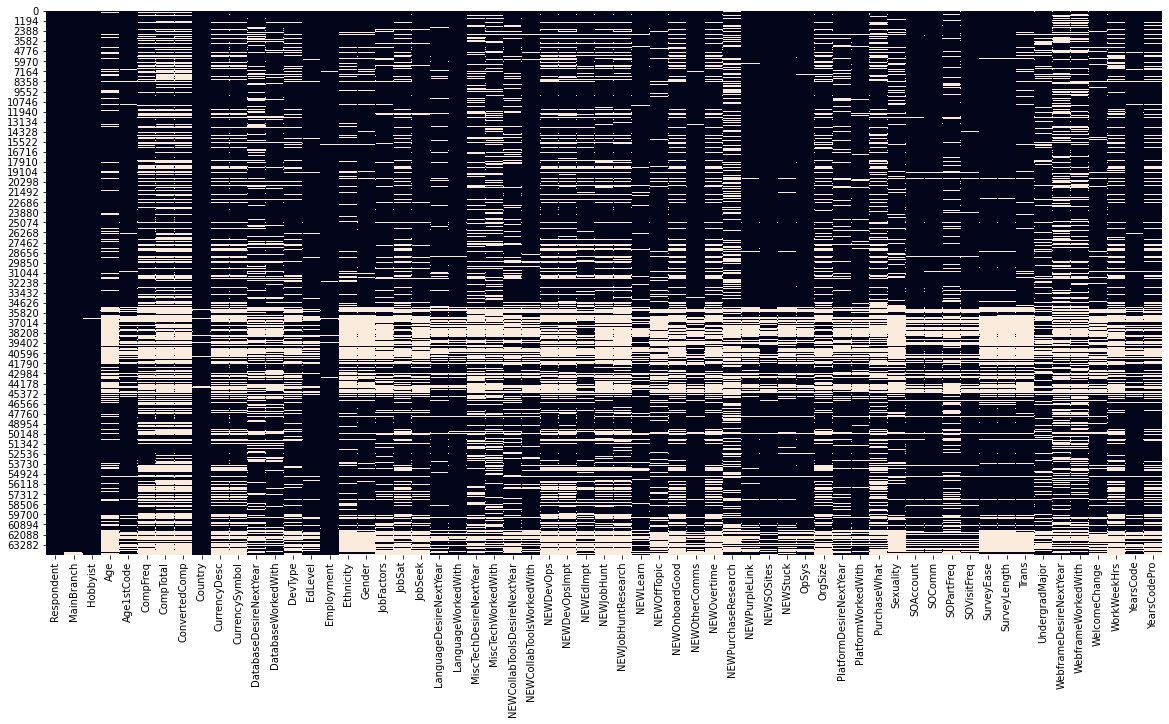

In [4]:
# Missing Values

import seaborn as sns
plt.figure(figsize = (20, 10))
sns.heatmap(df.isnull(), cbar = False)

<AxesSubplot:>

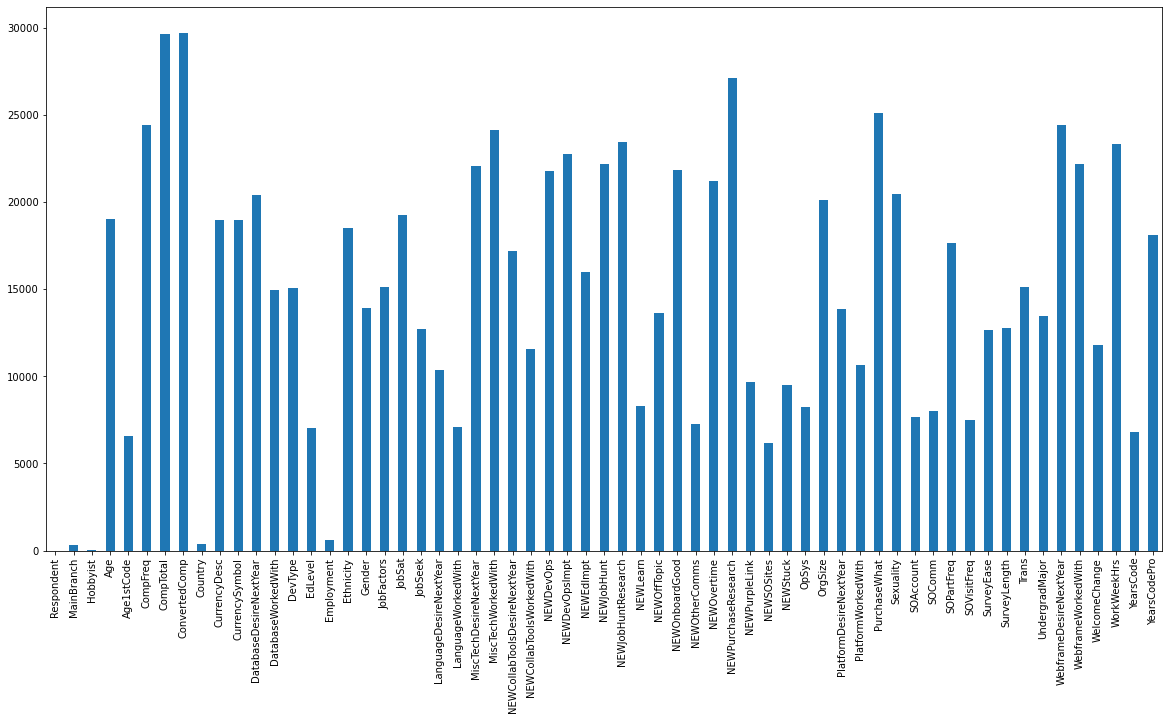

In [5]:
plt.figure(figsize = (20, 10))
missing_df = df.isnull().sum()
missing_df.plot(kind = "bar")

We can see many of the columns have very high number of missing values, so we will select only few most relevant columns.

**Selected Columns**
- Country : Country of Residence
- EdLevel : Highest level of formal education completed
- YearsCodePro : Number of years coded professionally
- Employment  : Current employment status
- ConvertedComp : Salary converted to annual USD salaries

In [6]:
# Selecting only few relevant columns

df = df[["Country", "EdLevel", "YearsCodePro", "Employment", "ConvertedComp"]]
df = df.rename({"ConvertedComp": "Salary"}, axis=1)
df.head()

,Country,EdLevel,YearsCodePro,Employment,Salary
0,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",27,"Independent contractor, freelancer, or self-em...",NaN
1,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,Employed full-time,NaN
2,Russian Federation,NaN,NaN,NaN,NaN
3,Albania,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,NaN,NaN
4,United States,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,Employed full-time,NaN


Since, we are predicting the Salary, we cannot have missing values for it. So, we will only keep records with non missing values for Salary

In [10]:
df = df[~ df['Salary'].isnull()]

In [11]:
df.isnull().sum()

Country           0
EdLevel         568
YearsCodePro    135
Employment       39
Salary            0
dtype: int64

 For simplicity, we will be just dropping the missing values.

In [12]:
# Further dropping missing values
df = df.dropna()
df.isnull().sum()

Country         0
EdLevel         0
YearsCodePro    0
Employment      0
Salary          0
dtype: int64

In [13]:
df.shape

(34025, 5)

### Exploring the Features

**Country**

In [14]:
# Exploring Country
df['Country'].value_counts()

United States                       8082
India                               2563
United Kingdom                      2551
Germany                             2206
Canada                              1293
                                    ... 
Monaco                                 1
Malawi                                 1
Brunei Darussalam                      1
Burkina Faso                           1
Saint Vincent and the Grenadines       1
Name: Country, Length: 159, dtype: int64

<AxesSubplot:ylabel='Frequency'>

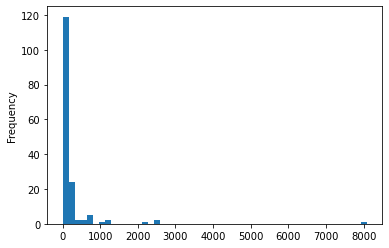

In [15]:
df['Country'].value_counts().plot(kind='hist', bins = 50)

We can see that there are many countires that appear very less in the data and as such modeling with such data would be difficult. So, we will regroup the less apperaring countries to a single group.

In [16]:
def regroup_country(country_count, cutoff):
    country_map = {}
    for i in range(len(country_count)):
        if country_count.values[i] >= cutoff:
            country_map[country_count.index[i]] = country_count.index[i]
        else:
            country_map[country_count.index[i]] = 'Other'
    return country_map

In [17]:
country_map = regroup_country(df.Country.value_counts(), 400)
df['Country'] = df['Country'].map(country_map)
df.Country.value_counts()

Other                 10174
United States          8082
India                  2563
United Kingdom         2551
Germany                2206
Canada                 1293
Brazil                 1139
France                 1103
Netherlands             798
Poland                  789
Australia               755
Spain                   744
Italy                   660
Russian Federation      595
Sweden                  573
Name: Country, dtype: int64

**Employment**

In [18]:
# Exploring Employment
df.Employment.value_counts()

Employed full-time                                      30019
Independent contractor, freelancer, or self-employed     2998
Employed part-time                                       1008
Name: Employment, dtype: int64

**Salary**

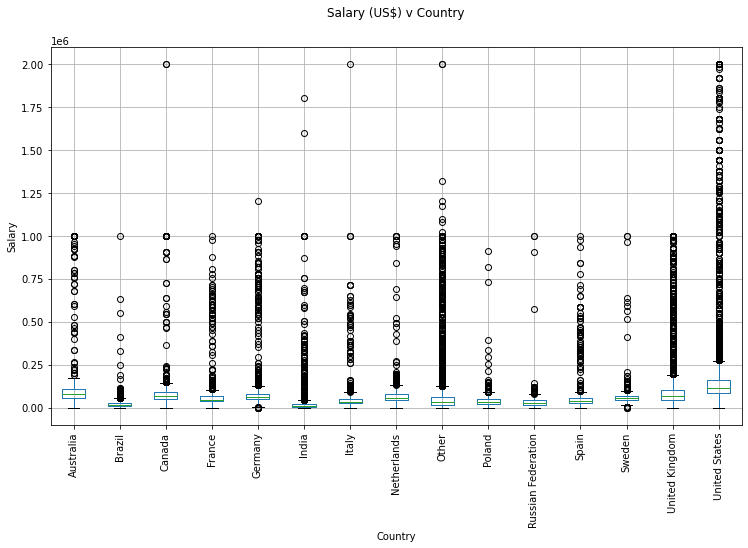

In [19]:
# Salary by country
fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

We can see that we have many outliers for the Salary columns, so we will process it to remove high outliers.

In [20]:
df = df[df["Salary"] <= 250000]
df = df[df["Salary"] >= 10000]
#df = df[df['Country'] != 'Other']

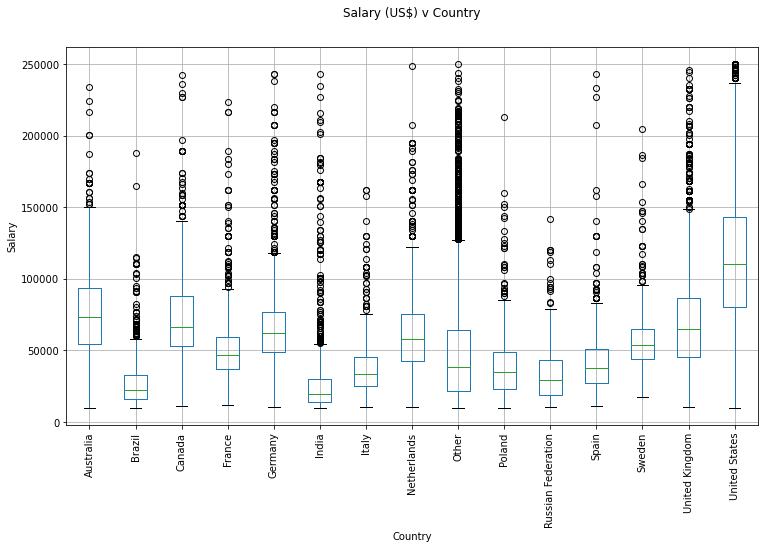

In [21]:
fig, ax = plt.subplots(1,1, figsize=(12, 7))
df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary (US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

**YearsCodePro**

In [23]:
# Exploring YearsCodePro
df["YearsCodePro"].unique()

array(['13', '4', '2', '7', '20', '1', '23', '3', '10', '14', '12', '29',
       '6', '28', '8', '15', '11', '25', '5', '9', 'Less than 1 year',
       '21', '16', '35', '18', '24', '32', '19', '22', '38', '30', '26',
       '17', '27', 'More than 50 years', '40', '34', '33', '36', '39',
       '37', '31', '41', '45', '50', '42', '43', '44', '48', '46', '49',
       '47'], dtype=object)

YearsCodePro is stored as string value and so we will convert to numerical.

In [24]:
def convert_experience(x):
    if x ==  'More than 50 years':
        return 50
    if x == 'Less than 1 year':
        return 0.5
    return float(x)

df['YearsCodePro'] = df['YearsCodePro'].apply(convert_experience)

**EdLevel**

In [25]:
# Exploring EdLevel
df["EdLevel"].unique()

array(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Some college/university study without earning a degree',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Associate degree (A.A., A.S., etc.)',
       'Professional degree (JD, MD, etc.)',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'Primary/elementary school',
       'I never completed any formal education'], dtype=object)

<AxesSubplot:>

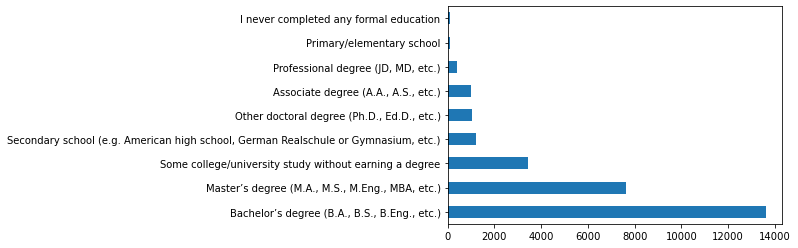

In [26]:
df["EdLevel"].value_counts().plot(kind = 'barh')

In [27]:
# processing the EdLevel
def process_education(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'Post grad'
    return 'Less than a Bachelors'

df['EdLevel'] = df['EdLevel'].apply(process_education)

In [28]:
df["EdLevel"].unique()

array(['Bachelor’s degree', 'Master’s degree', 'Less than a Bachelors',
       'Post grad'], dtype=object)

## Modeling

In [40]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('Salary',axis = 1), df['Salary'], test_size=0.2, random_state = 1)

In [42]:
#!pip install feature-engine

In [44]:
# Creating a Pipeline to Label Encode the categorical features
from sklearn.preprocessing import LabelEncoder
from feature_engine.encoding import OrdinalEncoder

cat_features = ['Country', 'EdLevel', 'Employment']
label_encoding = OrdinalEncoder(encoding_method = 'arbitrary', variables = cat_features)

# preprocessing pipeline
preprocess_pipeline = Pipeline([('preprocess', label_encoding)])

In [45]:
# transform the data with the pipeline
X_train = preprocess_pipeline.fit_transform(X_train)
X_test = preprocess_pipeline.transform(X_test)

In [48]:
X_train.head()

,Country,EdLevel,YearsCodePro,Employment
1771,0,0,10.0,0
2538,1,1,40.0,1
17484,1,2,15.0,1
34550,2,0,16.0,1
4052,3,1,16.0,0


**Linear Regression**

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [50]:
# Linear Regression
from sklearn.linear_model import LinearRegression

linear_reg= LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [51]:
y_pred = linear_reg.predict(X_test)

In [52]:
error = np.sqrt(mean_squared_error(y_test, y_pred))
error

40629.44112676978

**Decision Tree**

In [53]:
# Decision Tree

from sklearn.tree import DecisionTreeRegressor
dec_tree_reg = DecisionTreeRegressor(random_state=0)
dec_tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [54]:
y_pred = dec_tree_reg.predict(X_test)

error = np.sqrt(mean_squared_error(y_test, y_pred))
print("${:,.02f}".format(error))

$33,921.23


**Random Forest**

In [55]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
random_forest_reg = RandomForestRegressor(random_state=0)
random_forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [56]:
y_pred = random_forest_reg.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred))
print("${:,.02f}".format(error))

$33,102.09


In [57]:
# grid search for optimal hyperparameters

from sklearn.model_selection import GridSearchCV

parameters = {"n_estimators" : [100, 200, 400],
            "max_depth": [ 2,4,6,8,10,12]}

regressor = RandomForestRegressor(random_state=0,n_jobs = -1)
gs = GridSearchCV(regressor, parameters, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'n_estimators': [100, 200, 400]},
             scoring='neg_mean_squared_error')

In [58]:
gs.best_params_

{'max_depth': 8, 'n_estimators': 200}

In [59]:
y_pred = gs.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred))
print("${:,.02f}".format(error))

$32,378.84


In [60]:
# finally fitting the best model on the entire data

regressor = gs.best_estimator_
X = X_train.append(X_test)
y = y_train.append(y_test)

regressor.fit(X,y)
y_pred = regressor.predict(X)
error = np.sqrt(mean_squared_error(y, y_pred))
print("${:,.02f}".format(error))

$32,013.88


**Save the Model**

In [61]:
# save the final model
import pickle

# save the processing pipeline
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocess_pipeline, file)

# save model
with open('final_model.pkl', 'wb') as file:
    pickle.dump(regressor, file)

In [62]:
# checking with the sae model

with open('final_model.pkl', 'rb') as file:
    model = pickle.load(file)
    
with open('preprocessor.pkl', 'rb') as file:
    preprocessor = pickle.load(file)


In [68]:
# country, edlevel, yearscode, employment
X_sample = pd.DataFrame(np.array([["United States", 'Master’s degree', 15,"Employed full-time"]]),
                       columns = ['Country', 'EdLevel', 'YearsCodePro','Employment'])

X_sample = preprocessor.transform(X_sample)
X_sample

,Country,EdLevel,YearsCodePro,Employment
0,1,0,15,1


In [69]:
pred_sample = model.predict(X_sample)
pred_sample

array([140432.30537187])

In [72]:
df.groupby('Country')['Salary'].mean().sort_values(ascending = False)

Country
United States         115375.798240
Australia              78498.226940
Canada                 72781.566722
United Kingdom         72170.708630
Germany                65391.423188
Netherlands            64598.148052
Sweden                 58344.334539
France                 51290.135885
Other                  48517.203690
Spain                  42393.061674
Italy                  39298.242574
Poland                 39089.548128
Russian Federation     33841.643396
India                  29659.699683
Brazil                 27823.207838
Name: Salary, dtype: float64